In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
np.random.seed(42)

In [2]:
with pd.HDFStore('data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks'].index
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

start = 1988
end = 2018

monthly_returns = prices.loc[f'{start}':f'{end}'].resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.columns.names = ['Ticker']
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 1988-02-29 to 2018-03-31
Freq: M
Columns: 193 entries, MMM to XEL
dtypes: float64(193)
memory usage: 548.7 KB


In [3]:
monthly_returns.head()

Ticker,MMM,AOS,ABT,ADM,ADBE,ADP,AFL,APD,ALK,LNT,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
date,,,,,,,,,,,,,,,,,,,,,
1988-02-29,-0.016015,0.107451,0.066667,0.051373,0.094340,0.084912,-0.025965,0.163636,0.147541,0.038251,...,0.073046,-0.014866,0.077426,-0.137391,0.234043,0.134737,0.072335,0.142330,0.055649,-0.023039
1988-03-31,-0.025424,0.080028,-0.098462,-0.036145,0.068966,-0.081417,0.170749,-0.059891,-0.035429,-0.047368,...,-0.041615,-0.024438,-0.050562,-0.084677,0.026207,-0.101345,-0.053571,0.000000,0.014936,-0.024129
1988-04-30,0.028174,-0.057049,-0.020838,0.125000,0.129032,-0.058824,-0.068923,0.077986,0.121154,0.001899,...,-0.013158,0.020202,-0.014675,0.005232,0.024866,-0.025207,0.028302,0.159273,0.135318,-0.003984
1988-05-31,0.053712,0.000000,0.016217,-0.038069,0.007143,-0.031250,-0.074686,-0.059529,-0.086335,-0.002697,...,0.018018,0.050463,0.027195,0.082966,0.000000,-0.020000,-0.026255,-0.036158,-0.041457,0.041667
1988-06-30,0.068826,0.105263,-0.029545,-0.063800,0.141844,0.048455,-0.045000,0.119104,0.108406,0.047769,...,0.085369,0.014548,0.124260,-0.025085,0.008525,0.117551,0.095238,0.028976,-0.050530,0.012866


In [6]:
monthly_returns.tail()

Ticker,MMM,AOS,ABT,ADM,ADBE,ADP,AFL,APD,ALK,LNT,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
date,,,,,,,,,,,,,,,,,,,,,
2017-11-30,0.023633,0.071284,0.039462,-0.016209,0.036024,-0.015483,0.044701,0.022643,0.052309,0.042765,...,0.113618,0.031162,0.012824,-0.014497,-0.116613,-0.014759,0.028305,0.019298,0.119423,0.042205
2017-12-31,0.011162,-0.033743,0.012418,0.005015,-0.034331,0.023851,0.001597,0.006379,0.062744,-0.055420,...,0.015633,-0.044035,0.074376,-0.012609,0.008496,-0.003392,0.000415,0.049570,0.067507,-0.067816
2018-01-31,0.000000,0.089752,0.089189,0.071607,0.139922,0.054953,0.004785,0.026146,-0.105836,-0.067120,...,0.079494,-0.032064,0.084226,0.015506,0.118886,0.064663,0.075783,0.029518,0.141418,-0.051341
2018-02-28,0.000000,-0.038784,-0.029440,-0.033295,0.046906,-0.066974,0.007710,-0.045020,-0.018713,-0.027673,...,-0.155629,-0.068118,-0.112040,-0.129541,-0.021858,-0.066862,-0.104674,-0.115642,-0.030075,-0.051709
2018-03-31,-0.011290,-0.026640,-0.000829,0.032514,0.022331,-0.026788,-0.510801,-0.013434,-0.046667,0.048642,...,-0.043995,0.039720,-0.125150,-0.010892,0.059053,-0.003711,-0.059287,-0.094020,0.043892,0.042283


In [7]:
def get_inverse_var_pf(cov, **kargs):
    """Compute the inverse-variance portfolio"""
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
        0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

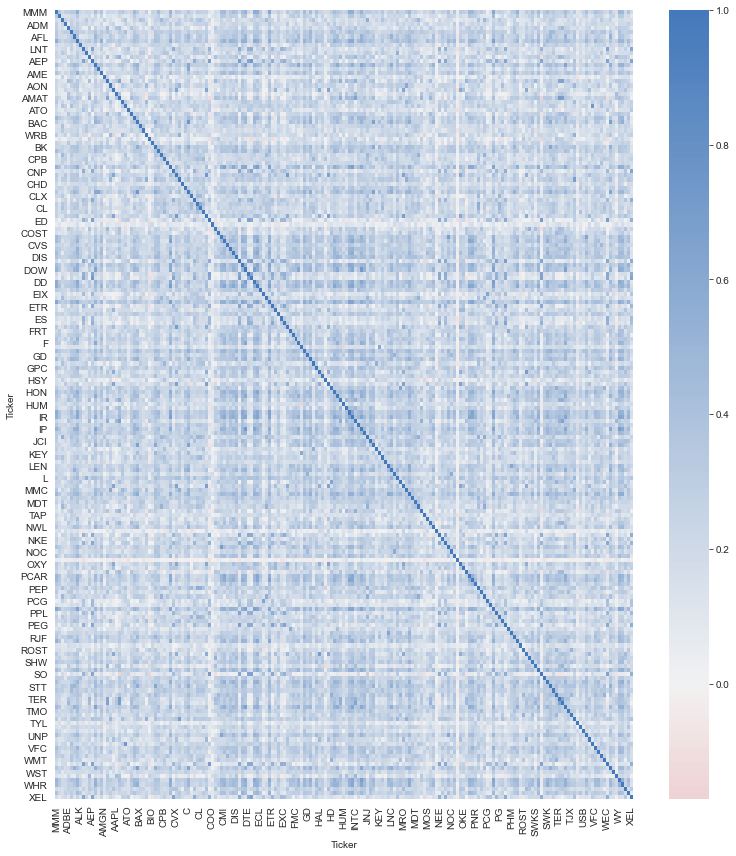

In [9]:
# Get Correlation Matrix
cov = monthly_returns.cov()
corr = monthly_returns.corr()
corr.columns.names=['Ticker']
cmap = sns.diverging_palette(10, 250, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,12))
sns.heatmap(corr, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()

In [12]:
# Cluster Return Series
def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'single')
sorted_idx = quasi_diagonalize(linkage_matrix)

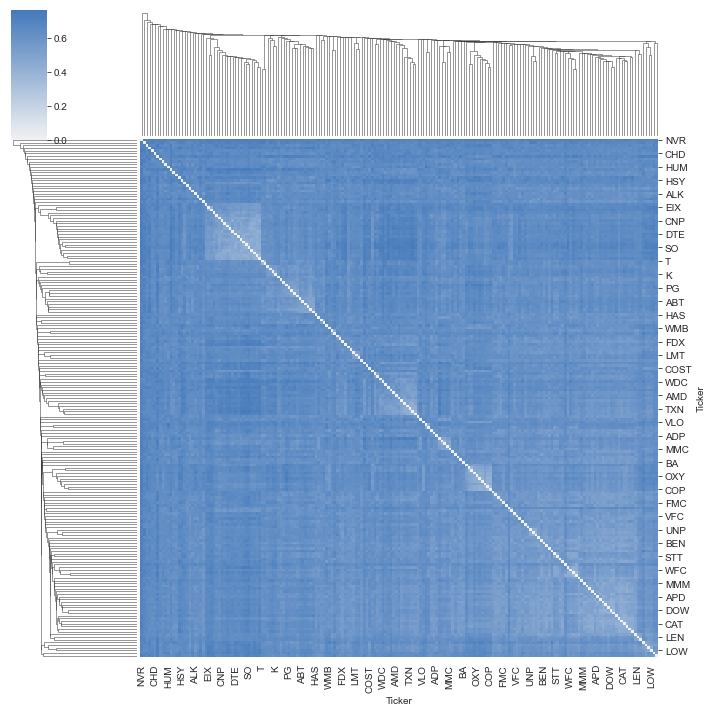

In [13]:
# Plot Cluster Map
clustergrid = sns.clustermap(distance_matrix, method='single', row_linkage=linkage_matrix,
                             col_linkage=linkage_matrix, cmap=cmap, center=0);

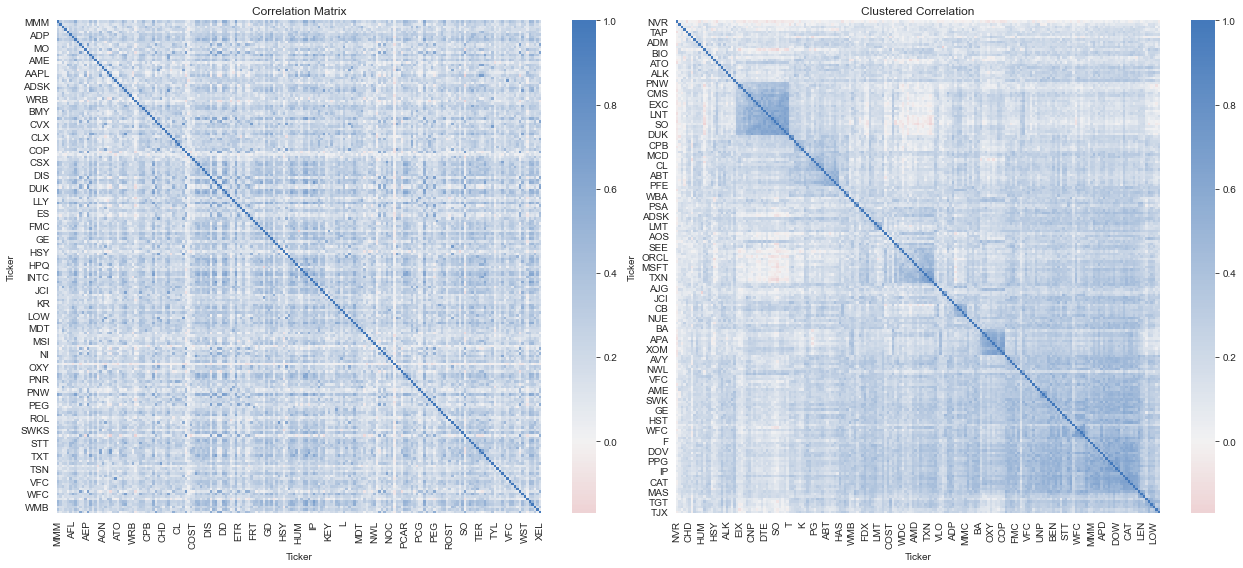

In [14]:
sorted_idx = clustergrid.dendrogram_row.reordered_ind
sorted_tickers = corr.index[sorted_idx].tolist()
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

In [16]:
# Compute Allocation
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_var_pf(cov_)
    return (w_ @ cov_ @ w_).item()

def get_hrp_allocation(cov, tickers):
    """Compute top-down HRP weights"""

    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets

    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]
        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(cov, cluster0)
            cluster1_var = get_cluster_var(cov, cluster1)

            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler
    return weights

hrp_allocation = get_hrp_allocation(cov, sorted_tickers)

In [17]:
hrp_allocation.tail()

TGT     0.003215
HD      0.002445
LOW     0.001634
ROST    0.001249
TJX     0.002086
dtype: float64

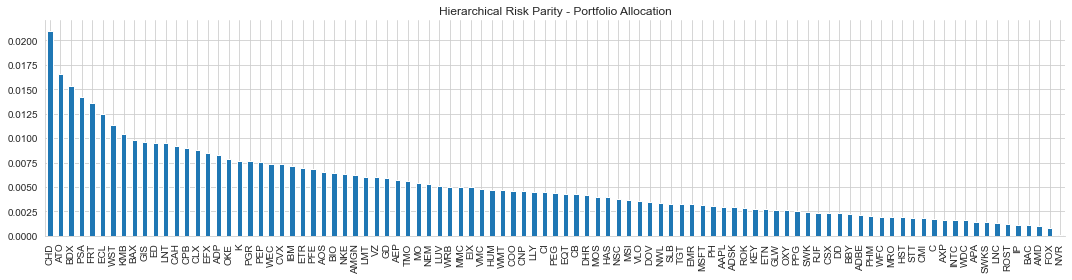

In [18]:
# Visualize the result
title = 'Hierarchical Risk Parity - Portfolio Allocation'
hrp_allocation.sort_values(ascending=False).iloc[::2].plot.bar(figsize=(15, 4), title=title)
sns.despine()
plt.tight_layout()

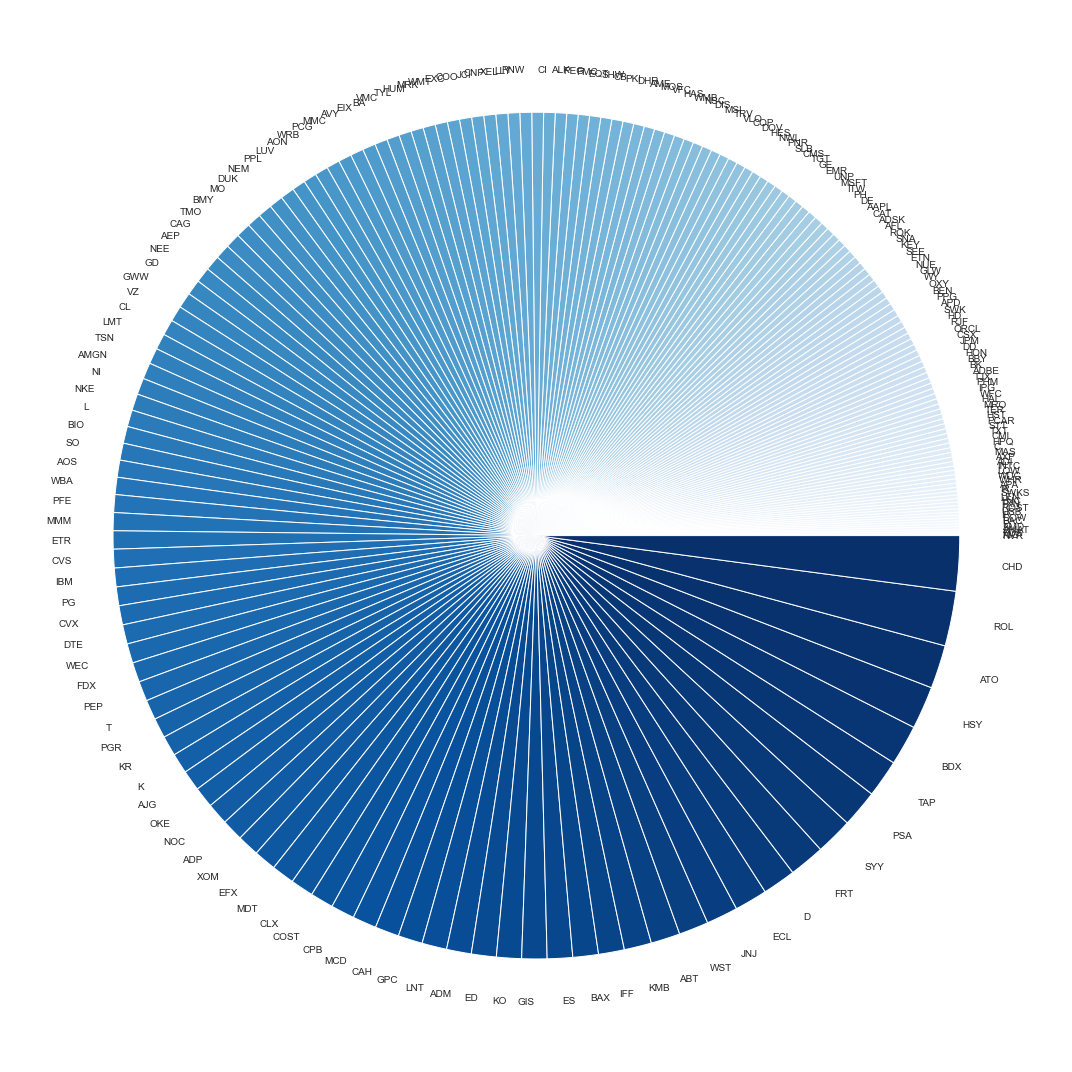

In [19]:
ax = hrp_allocation.sort_values().plot.pie(figsize=(15, 15), cmap='Blues')
ax.set_ylabel('')
plt.tight_layout();